In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes, wrap_dataset_for_transforms_v2
from torchvision.transforms.v2 import (
    Compose,
    Normalize,
    Resize,
    ToImage,
    ToDtype,
)
from unet import UNet
from torch import optim 
from utils import *
import wandb
from torchvision.utils import make_grid
import os
from collections import Counter
from torchvision.datasets import Cityscapes
from tqdm import tqdm
from torch.utils.data import Dataset

import torch.nn.functional as F


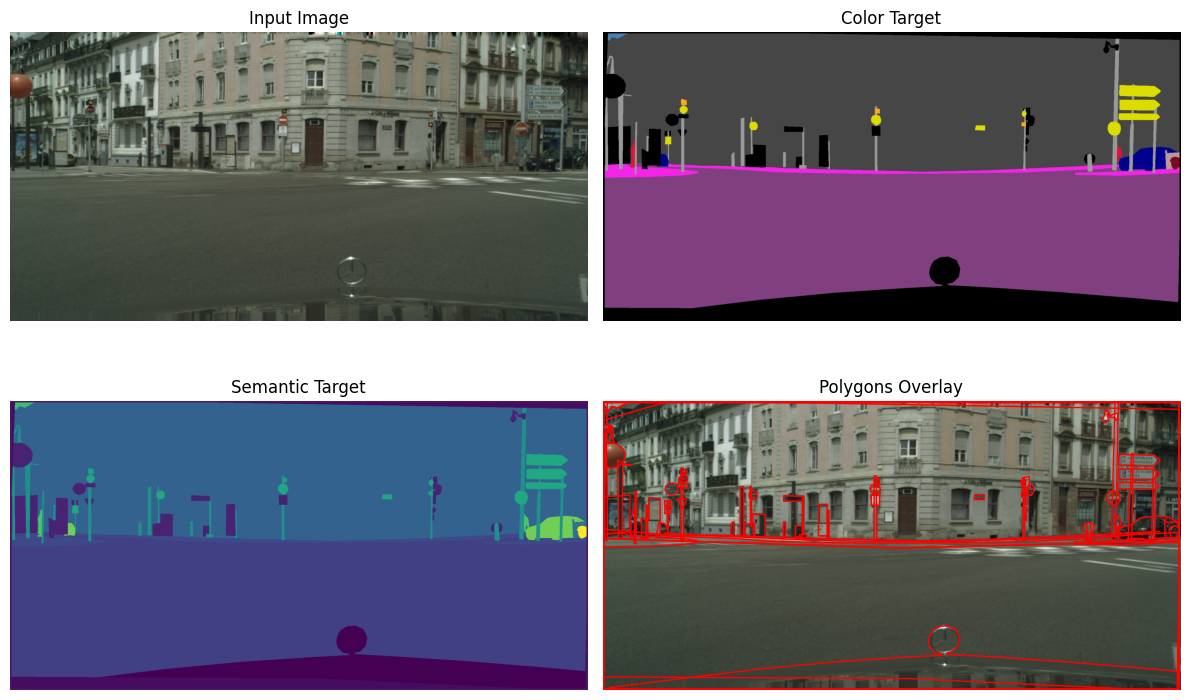

In [121]:
from torchvision.datasets import Cityscapes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Dataset with no transform to preserve raw image and targets
raw_dataset = Cityscapes(
    '/Users/christosntokos/Downloads/data/cityscapes',
    split="train",
    mode="fine",
    target_type=["semantic", "polygon", "color"],
    transforms=None
)

# Get the raw image and targets
image, (semantic_target, polygon_target, color_target) = raw_dataset[0]

# Show the input image and the various targets
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Color Target")
plt.imshow(color_target)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Semantic Target")
plt.imshow(semantic_target)
plt.axis("off")

# Polygon annotations overlaid on input image
plt.subplot(2, 2, 4)
plt.title("Polygons Overlay")
plt.imshow(image)
ax = plt.gca()

for obj in polygon_target['objects']:
    polygon = obj['polygon']
    patch = patches.Polygon(polygon, closed=True, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(patch)

plt.axis("off")
plt.tight_layout()
plt.show()


In [160]:
import numpy as np
import torchvision
print(torchvision.__version__)
Cityscapes.classes

1.26.4
0.21.0


[CityscapesClass(name='unlabeled', id=0, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='ego vehicle', id=1, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='rectification border', id=2, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='out of roi', id=3, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='static', id=4, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(0, 0, 0)),
 CityscapesClass(name='dynamic', id=5, train_id=255, category='void', category_id=0, has_instances=False, ignore_in_eval=True, color=(111, 74, 0)),
 CityscapesClass(name='ground', id=6, train_id=255, category='void', category_id=0, has_instances=False, i

In [252]:
for i in Cityscapes.classes:
    print(i.id, i.train_id, i.name, i.category, i.category_id, i.color)


semantic_classes_set = set()
for i in Cityscapes.classes:
    semantic_classes_set.add(i.name)
print(semantic_classes_set)

0 255 unlabeled void 0 (0, 0, 0)
1 255 ego vehicle void 0 (0, 0, 0)
2 255 rectification border void 0 (0, 0, 0)
3 255 out of roi void 0 (0, 0, 0)
4 255 static void 0 (0, 0, 0)
5 255 dynamic void 0 (111, 74, 0)
6 255 ground void 0 (81, 0, 81)
7 0 road flat 1 (128, 64, 128)
8 1 sidewalk flat 1 (244, 35, 232)
9 255 parking flat 1 (250, 170, 160)
10 255 rail track flat 1 (230, 150, 140)
11 2 building construction 2 (70, 70, 70)
12 3 wall construction 2 (102, 102, 156)
13 4 fence construction 2 (190, 153, 153)
14 255 guard rail construction 2 (180, 165, 180)
15 255 bridge construction 2 (150, 100, 100)
16 255 tunnel construction 2 (150, 120, 90)
17 5 pole object 3 (153, 153, 153)
18 255 polegroup object 3 (153, 153, 153)
19 6 traffic light object 3 (250, 170, 30)
20 7 traffic sign object 3 (220, 220, 0)
21 8 vegetation nature 4 (107, 142, 35)
22 9 terrain nature 4 (152, 251, 152)
23 10 sky sky 5 (70, 130, 180)
24 11 person human 6 (220, 20, 60)
25 12 rider human 6 (255, 0, 0)
26 13 car vehi

In [83]:
# map the class names to 
semantic_label_to_id = { i.name: i.id for i in Cityscapes.classes }
print(semantic_label_to_id)
semantic_label_to_train_id = { i.name: i.train_id for i in Cityscapes.classes }
print(semantic_label_to_train_id)

{'unlabeled': 0, 'ego vehicle': 1, 'rectification border': 2, 'out of roi': 3, 'static': 4, 'dynamic': 5, 'ground': 6, 'road': 7, 'sidewalk': 8, 'parking': 9, 'rail track': 10, 'building': 11, 'wall': 12, 'fence': 13, 'guard rail': 14, 'bridge': 15, 'tunnel': 16, 'pole': 17, 'polegroup': 18, 'traffic light': 19, 'traffic sign': 20, 'vegetation': 21, 'terrain': 22, 'sky': 23, 'person': 24, 'rider': 25, 'car': 26, 'truck': 27, 'bus': 28, 'caravan': 29, 'trailer': 30, 'train': 31, 'motorcycle': 32, 'bicycle': 33, 'license plate': -1}
{'unlabeled': 255, 'ego vehicle': 255, 'rectification border': 255, 'out of roi': 255, 'static': 255, 'dynamic': 255, 'ground': 255, 'road': 0, 'sidewalk': 1, 'parking': 255, 'rail track': 255, 'building': 2, 'wall': 3, 'fence': 4, 'guard rail': 255, 'bridge': 255, 'tunnel': 255, 'pole': 5, 'polegroup': 255, 'traffic light': 6, 'traffic sign': 7, 'vegetation': 8, 'terrain': 9, 'sky': 10, 'person': 11, 'rider': 12, 'car': 13, 'truck': 14, 'bus': 15, 'caravan':

In [241]:
id_to_trainid = {cls.id: cls.train_id for cls in Cityscapes.classes}
print(id_to_trainid)

# print unique train_ids len 
print(len(set(id_to_trainid.values())))

{0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255, 7: 0, 8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4, 14: 255, 15: 255, 16: 255, 17: 5, 18: 255, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 255, 30: 255, 31: 16, 32: 17, 33: 18, -1: -1}
21


In [85]:
train_id_to_color = {cls.train_id: cls.color for cls in Cityscapes.classes if cls.train_id != 255}
train_id_to_color[255] = (0, 0, 0)  # Assign black to ignored labels
print(train_id_to_color)

{0: (128, 64, 128), 1: (244, 35, 232), 2: (70, 70, 70), 3: (102, 102, 156), 4: (190, 153, 153), 5: (153, 153, 153), 6: (250, 170, 30), 7: (220, 220, 0), 8: (107, 142, 35), 9: (152, 251, 152), 10: (70, 130, 180), 11: (220, 20, 60), 12: (255, 0, 0), 13: (0, 0, 142), 14: (0, 0, 70), 15: (0, 60, 100), 16: (0, 80, 100), 17: (0, 0, 230), 18: (119, 11, 32), -1: (0, 0, 142), 255: (0, 0, 0)}


In [4]:
dataset_tain = Cityscapes(
    root='/Users/christosntokos/Downloads/data/cityscapes',
    split="train",
    mode="fine",
    target_type="semantic",
    transforms=None
)

dataset_val = Cityscapes(
    root='/Users/christosntokos/Downloads/data/cityscapes',
    split="val",
    mode="fine",
    target_type="semantic",
    transforms=None
)

print(len(dataset_tain))
print(len(dataset_val))

2472
503


In [239]:
dataset = Cityscapes(
    root='/Users/christosntokos/Downloads/data/cityscapes',
    split="train",
    mode="fine",
    target_type="polygon",
    transforms=None
)

# print the unique classes in the dataset
unique_classes = set()
for _, (_, objects) in enumerate(dataset):
    for obj in objects['objects']:
        unique_classes.add(obj['label'])

print("Unique classes in the dataset:")
for cls in unique_classes:
    print(cls)

print("len unique classes", len(unique_classes))
# Check the number of unique classes in the dataset

Unique classes in the dataset:
vegetation
dynamic
bicycle
static
building
rectification border
guard rail
parking
bicyclegroup
traffic sign
caravan
ridergroup
polegroup
wall
rail track
tunnel
sky
ego vehicle
out of roi
car
license plate
motorcycle
sidewalk
traffic light
trailer
pole
rider
fence
cargroup
train
person
motorcyclegroup
ground
truck
terrain
road
persongroup
bridge
bus
len unique classes 39


In [254]:
print(semantic_classes_set - unique_classes)
print(unique_classes - semantic_classes_set)

{'unlabeled'}
{'persongroup', 'ridergroup', 'cargroup', 'bicyclegroup', 'motorcyclegroup'}


In [250]:
semantic_to_polygon = {
    'road': ['road', 'rectification border'],
    'sidewalk': ['sidewalk'],
    'building': ['building'],
    'wall': ['wall'],
    'fence': ['fence', 'guard rail'],
    'pole': ['pole', 'polegroup'],
    'traffic light': ['traffic light'],
    'traffic sign': ['traffic sign'],
    'vegetation': ['vegetation'],
    'terrain': ['terrain'],
    'sky': ['sky'],
    'person': ['person', 'persongroup'],
    'rider': ['rider', 'ridergroup'],
    'car': ['car', 'cargroup'],
    'truck': ['truck'],
    'bus': ['bus'],
    'train': ['train'],
    'motorcycle': ['motorcycle', 'motorcyclegroup'],
    'bicycle': ['bicycle', 'bicyclegroup'],
    'license plate': ['license plate'],
    'dynamic': ['dynamic'],
    'static': ['static'],
    'parking': ['parking'],
    'caravan': ['caravan'],
    'rail track': ['rail track'],
    'tunnel': ['tunnel'],
    'ego vehicle': ['ego vehicle'],
    'out of roi': ['out of roi'],
    'trailer': ['trailer'],
    'ground': ['ground'],
    'bridge': ['bridge']
}

print(len(semantic_to_polygon))
# print of unique values 
unique_polygon_labels = set()
for semantic_label, polygon_labels in semantic_to_polygon.items():
    for polygon_label in polygon_labels:
        unique_polygon_labels.add(polygon_label)
print("Unique polygon labels:", len(unique_polygon_labels))

31
Unique polygon labels: 39


In [255]:
polygon_to_semantic = {
    'rectification border': 'road',
    'dynamic': 'dynamic',
    'static': 'static',
    'out of roi': 'out of roi',
    'road': 'road',
    'sidewalk': 'sidewalk',
    'building': 'building',
    'wall': 'wall',
    'fence': 'fence',
    'guard rail': 'fence',
    'pole': 'pole',
    'polegroup': 'pole',
    'traffic light': 'traffic light',
    'traffic sign': 'traffic sign',
    'vegetation': 'vegetation',
    'terrain': 'terrain',
    'sky': 'sky',
    'person': 'person',
    'persongroup': 'person',
    'rider': 'rider',
    'ridergroup': 'rider',
    'car': 'car',
    'cargroup': 'car',
    'truck': 'truck',
    'bus': 'bus',
    'train': 'train',
    'motorcycle': 'motorcycle',
    'motorcyclegroup': 'motorcycle',
    'bicycle': 'bicycle',
    'bicyclegroup': 'bicycle',
    'ground': 'ground',
    'license plate': 'license plate',
    'ego vehicle': 'ego vehicle',
    'bridge': 'bridge',
    'rail track': 'rail track',
    'parking': 'parking',
    'caravan': 'caravan',
    'trailer': 'trailer',
    'tunnel': 'tunnel'
}
print("len polygon_to_semantic", len(polygon_to_semantic))


len polygon_to_semantic 39


In [256]:

# Initialize a Counter to tally occurrences of each label
label_counter = Counter()

# Iterate over the dataset with a progress bar
for i in tqdm(range(len(dataset))):
    _, target = dataset[i]

    # Expecting target to be a dictionary with key "objects"
    objects = target.get("objects", [])
    
    for obj in objects:
        # Get the label
        label = obj.get("label", None)
        semantic_label = polygon_to_semantic.get(label, None)
        if semantic_label is None:
            print(f"Warning: Label '{label}' not found in polygon_to_semantic mapping. Skipping.")
            continue

        if label:
            label_counter[semantic_label] += 1

# Print the total occurrences for each label
print("Occurrences of each label in the polygon dataset by semantic label:")
for label, count in sorted(label_counter.items()):
    print(f"Label '{label}': {count} occurrences")

print("len label_counter", len(label_counter))

100%|██████████| 2472/2472 [02:25<00:00, 16.96it/s]

Occurrences of each label in the polygon dataset by semantic label:
Label 'bicycle': 4028 occurrences
Label 'bridge': 382 occurrences
Label 'building': 5787 occurrences
Label 'bus': 329 occurrences
Label 'car': 25359 occurrences
Label 'caravan': 56 occurrences
Label 'dynamic': 2869 occurrences
Label 'ego vehicle': 2472 occurrences
Label 'fence': 2036 occurrences
Label 'ground': 1519 occurrences
Label 'license plate': 4946 occurrences
Label 'motorcycle': 592 occurrences
Label 'out of roi': 2472 occurrences
Label 'parking': 955 occurrences
Label 'person': 16663 occurrences
Label 'pole': 37678 occurrences
Label 'rail track': 112 occurrences
Label 'rider': 1495 occurrences
Label 'road': 7010 occurrences
Label 'sidewalk': 6006 occurrences
Label 'sky': 2462 occurrences
Label 'static': 32985 occurrences
Label 'terrain': 3769 occurrences
Label 'traffic light': 9028 occurrences
Label 'traffic sign': 18228 occurrences
Label 'trailer': 67 occurrences
Label 'train': 133 occurrences
Label 'truck': 

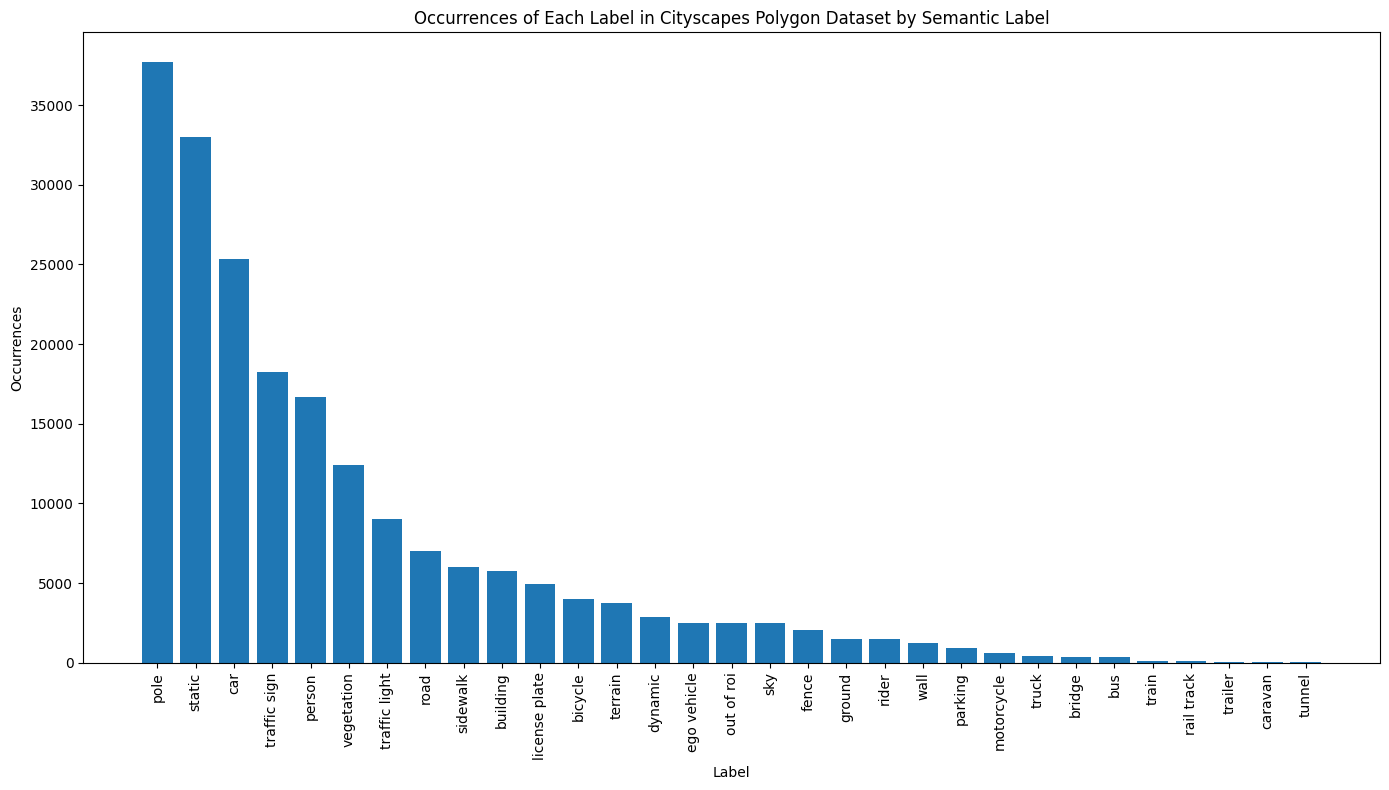

In [257]:

# Sort by descending count
sorted_labels = sorted(label_counter.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_labels)

# Create the plot
plt.figure(figsize=(14, 8))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.title("Occurrences of Each Label in Cityscapes Polygon Dataset by Semantic Label")
plt.xlabel("Label")
plt.ylabel("Occurrences")
plt.tight_layout()
plt.show()

In [290]:
# uing semantic_label_to_train_id get the train id dict of accurances from the label_counter
train_id_counter = Counter()
for label, count in label_counter.items():
    train_id = semantic_label_to_train_id.get(label, None)
    if train_id is not None:
        train_id_counter[train_id] += count

# remove the 255 id from the train_id_counter
train_id_counter.pop(255, None)
# remove the -1 id from the train_id_counter
train_id_counter.pop(-1, None)
print("Occurrences of each label in the polygon dataset by train id:")
for label, count in sorted(train_id_counter.items()):
    print(f"Label '{label}': {count} occurrences")



Occurrences of each label in the polygon dataset by train id:
Label '0': 7010 occurrences
Label '1': 6006 occurrences
Label '2': 5787 occurrences
Label '3': 1218 occurrences
Label '4': 2036 occurrences
Label '5': 37678 occurrences
Label '6': 9028 occurrences
Label '7': 18228 occurrences
Label '8': 12397 occurrences
Label '9': 3769 occurrences
Label '10': 2462 occurrences
Label '11': 16663 occurrences
Label '12': 1495 occurrences
Label '13': 25359 occurrences
Label '14': 429 occurrences
Label '15': 329 occurrences
Label '16': 133 occurrences
Label '17': 592 occurrences
Label '18': 4028 occurrences


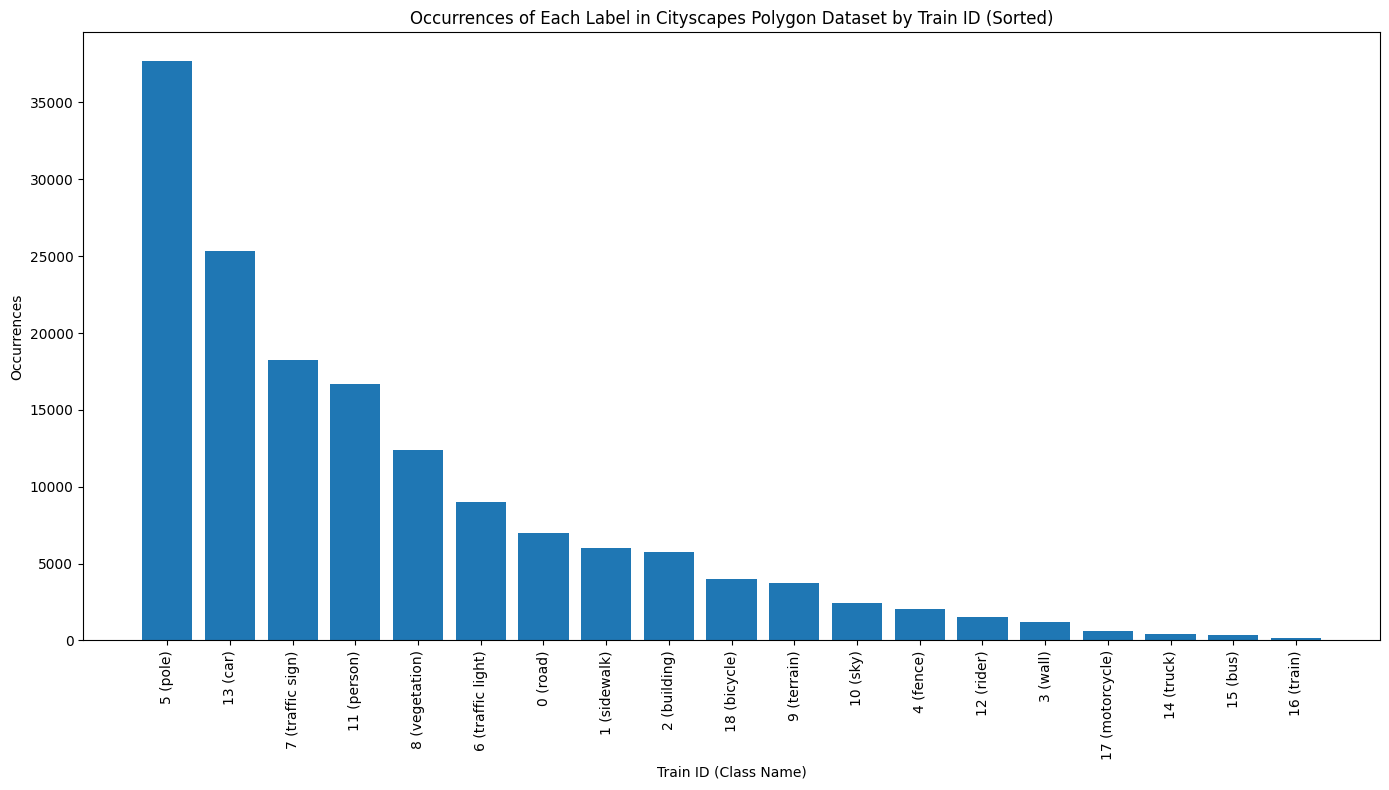

In [291]:
# Sort train_id_counter by descending count
sorted_trainid = sorted(train_id_counter.items(), key=lambda x: x[1], reverse=True)

# Extract train IDs and counts
ids, counts = zip(*sorted_trainid)
# make ids sttrings

# Map train IDs to class names
train_id_to_class_name = {v: k for k, v in semantic_label_to_train_id.items()}
x_labels = [f"{train_id} ({train_id_to_class_name.get(train_id, 'Unknown')})" for train_id in ids]

ids = [str(id) for id in ids]

# Create the plot
plt.figure(figsize=(14, 8))
plt.bar(ids, counts)  # Use counts for the bar heights
plt.xticks(ids, x_labels, rotation=90)  # Set the IDs and class names as x-axis labels
plt.title("Occurrences of Each Label in Cityscapes Polygon Dataset by Train ID (Sorted)")
plt.xlabel("Train ID (Class Name)")
plt.ylabel("Occurrences")
plt.tight_layout()
plt.show()


In [295]:
import torch
import numpy as np

num_classes = 19  # Cityscapes classes
class_counts = np.array([train_id_counter.get(i, 0) for i in range(num_classes)])
print("class_counts", class_counts)
# Compute class weights (inverse frequency)
class_weights = 1 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
class_weights_tensor = torch.FloatTensor(class_weights)

print("Class weights:", class_weights)

class_counts [ 7010  6006  5787  1218  2036 37678  9028 18228 12397  3769  2462 16663
  1495 25359   429   329   133   592  4028]
Class weights: [0.14783885 0.17255251 0.17908249 0.85086237 0.50901295 0.02750545
 0.11479291 0.05685486 0.08359687 0.27496693 0.42093841 0.0621947
 0.69321095 0.04086716 2.41573511 3.1500011  7.79210796 1.75059183
 0.25728659]


In [277]:
# get from label_counter the labels that are less than 1000
low_count_labels = {label: count for label, count in label_counter.items() if count < 5000}
print("Labels with less than 5000 occurrences:")
for label, count in low_count_labels.items():
    print(f"Label '{label}': {count} occurrences")


low_count_ids = {semantic_label_to_id[label]: count for label, count in low_count_labels.items() if label in semantic_label_to_id}
# Print the IDs and their counts
print("IDs with less than 5000 occurrences:")
for id, count in low_count_ids.items():
    print(f"ID '{id}': {count} occurrences")


low_count_train_ids = {semantic_label_to_train_id[label]: count for label, count in low_count_labels.items() if label in semantic_label_to_id}
# Print the train IDs and their counts
print("Train IDs with less than 15000 occurrences:")
for train_id, count in low_count_train_ids.items():
    print(f"Train ID '{train_id}': {count} occurrences")

Labels with less than 5000 occurrences:
Label 'sky': 2462 occurrences
Label 'fence': 2036 occurrences
Label 'bicycle': 4028 occurrences
Label 'ego vehicle': 2472 occurrences
Label 'out of roi': 2472 occurrences
Label 'rail track': 112 occurrences
Label 'dynamic': 2869 occurrences
Label 'motorcycle': 592 occurrences
Label 'train': 133 occurrences
Label 'rider': 1495 occurrences
Label 'terrain': 3769 occurrences
Label 'bridge': 382 occurrences
Label 'license plate': 4946 occurrences
Label 'wall': 1218 occurrences
Label 'parking': 955 occurrences
Label 'ground': 1519 occurrences
Label 'truck': 429 occurrences
Label 'caravan': 56 occurrences
Label 'bus': 329 occurrences
Label 'trailer': 67 occurrences
Label 'tunnel': 27 occurrences
IDs with less than 5000 occurrences:
ID '23': 2462 occurrences
ID '13': 2036 occurrences
ID '33': 4028 occurrences
ID '1': 2472 occurrences
ID '3': 2472 occurrences
ID '10': 112 occurrences
ID '5': 2869 occurrences
ID '32': 592 occurrences
ID '31': 133 occurrenc

In [238]:
# calculate number of unique train ids in total
count_labels = {label: count for label, count in label_counter.items()}
print("unique_classes", len(unique_classes))


count_train_ids = {semantic_label_to_train_id[label]: count for label, count in count_labels.items() if label in semantic_label_to_id}
print("unique_train_ids", len(count_train_ids))

sorted_train_ids = sorted(count_train_ids.items(), key=lambda x: x[0], reverse=True)
sorted_train_ids

unique_classes 39
unique_train_ids 21


[(255, 27),
 (18, 4028),
 (17, 592),
 (16, 133),
 (15, 329),
 (14, 429),
 (13, 25359),
 (12, 1495),
 (11, 16663),
 (10, 2462),
 (9, 3769),
 (8, 12397),
 (7, 18228),
 (6, 9028),
 (5, 37678),
 (4, 2036),
 (3, 1218),
 (2, 5787),
 (1, 6006),
 (0, 7010),
 (-1, 4946)]

In [236]:
class RareClassBoostedDataset(Dataset):

    """
    A dataset wrapper that boosts the sampling of rare classes in a dataset.
    """
    def __init__(self, base_dataset, id_to_trainid, rare_train_ids: set, rare_sample_multiplier=3):
        self.base_dataset = base_dataset # The base dataset to wrap
        self.id_to_trainid = id_to_trainid # Mapping from IDs to train IDs
        self.rare_train_ids = rare_train_ids # The set of rare train IDs to boost
        self.rare_sample_multiplier = rare_sample_multiplier # The multiplier for boosting rare classes
        self.rare_indices = self._find_rare_indices() # Find the indices of rare samples in the base dataset
        self.indices = list(range(len(base_dataset))) + self.rare_indices * (self.rare_sample_multiplier - 1) # Create the final indices list

    def _find_rare_indices(self):
        rare_indices = []
        for idx in tqdm(range(len(self.base_dataset))):
            _, label_image = self.base_dataset[idx]
            labels_set = set(label_image.flatten().numpy())

            if any(train_id in self.rare_train_ids for train_id in labels_set):
                rare_indices.append(idx)

        print(f"Found {len(rare_indices)} rare samples out of {len(self.base_dataset)} total.")
        return rare_indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        real_index = self.indices[index]
        return self.base_dataset[real_index]


In [77]:
# delete this 
rare_train_ids = set(low_count_train_ids.keys())  # From your code
print(f"Rare train IDs: {rare_train_ids}")

# remove the 255 id from the rare train ids
rare_train_ids.discard(255)  # Remove the ignored label ID

def custom_transform(img, semantic_target):
    img = image_transform(img)
    semantic_target = label_transform(semantic_target)
    semantic_target = convert_to_train_id(semantic_target, id_to_trainid)
    return img, semantic_target

rare_indices = []

train_dataset_raw = Cityscapes(
    root='/Users/christosntokos/Downloads/data/cityscapes', 
    split="train",
    mode="fine",
    target_type="semantic",
    transforms=custom_transform
)

for idx in tqdm(range(len(train_dataset_raw))):

    _, label_image = train_dataset_raw[idx]
    labels_set = set(label_image.flatten().numpy())

    if any(train_id in rare_train_ids for train_id in labels_set):
        rare_indices.append(idx)

print(f"Found {len(rare_indices)} rare samples out of {len(train_dataset_raw)} total.")


Rare train IDs: {14, 15, 16, 17, 255}


100%|██████████| 2472/2472 [05:14<00:00,  7.86it/s]

Found 920 rare samples out of 2472 total.


In [211]:
rare_train_ids = set(low_count_train_ids.keys())  # From your code
print(f"Rare train IDs: {rare_train_ids}")

# remove the 255 id from the rare train ids
rare_train_ids.discard(255)  # Remove the ignored label ID

def custom_transform(img, semantic_target):
    img = image_transform(img)
    semantic_target = label_transform(semantic_target)
    semantic_target = convert_to_train_id(semantic_target, id_to_trainid)
    return img, semantic_target


train_dataset_raw = Cityscapes(
    root='/Users/christosntokos/Downloads/data/cityscapes', 
    split="train",
    mode="fine",
    target_type="semantic",
    transforms=custom_transform
)
print(f"Loaded {len(train_dataset_raw)} samples from the raw dataset.")

train_dataset = RareClassBoostedDataset(
    base_dataset=train_dataset_raw,
    id_to_trainid=id_to_trainid,
    rare_train_ids=rare_train_ids,
    rare_sample_multiplier=3  # Boost each rare-sample image 3x total
)


Rare train IDs: {14, 15, 16, 17, 255}
Loaded 2472 samples from the raw dataset.


100%|██████████| 2472/2472 [05:07<00:00,  8.03it/s]

Found 920 rare samples out of 2472 total.


In [214]:
# print number of samples in the train_dataset_raw
print(f"Number of samples in the original dataset: {len(train_dataset_raw)}")

# print number of samples in the train_dataset
print(f"Number of samples in the boosted dataset: {len(train_dataset)}")

Number of samples in the original dataset: 2472
Number of samples in the boosted dataset: 4312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Image shape: torch.Size([3, 256, 256])
Label shape: torch.Size([256, 256])
<class 'torchvision.tv_tensors._image.Image'>


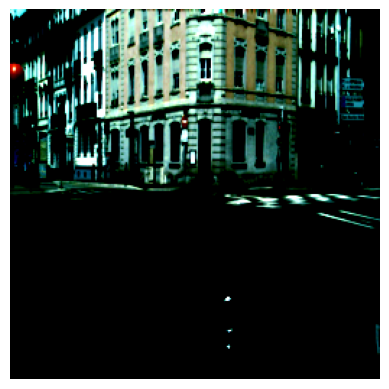

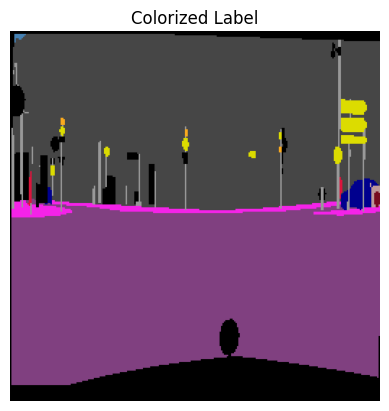

In [227]:
index = 0 # Modify the index as needed

# Assuming first_sample is already loaded as part of your code
first_sample = train_dataset[index]  # Modify the index as needed

image, label = first_sample

print(f"Image shape: {image.shape}")
print(f"Label shape: {label.shape}")
print(type(image))

# visualize the image tensor and label tensor
visualize_tv_image(image)

# use train_id_to_color to convert the label to color
def convert_label_to_color(label):
    color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for train_id, color in train_id_to_color.items():
        color_label[label == train_id] = color
    return color_label


color_label = convert_label_to_color(label)
plt.imshow(color_label)
plt.title("Colorized Label")
plt.axis("off")
plt.show()


In [217]:
#train_dataset = wrap_dataset_for_transforms_v2(train_dataset)
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0, 
    pin_memory=True
)

Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])


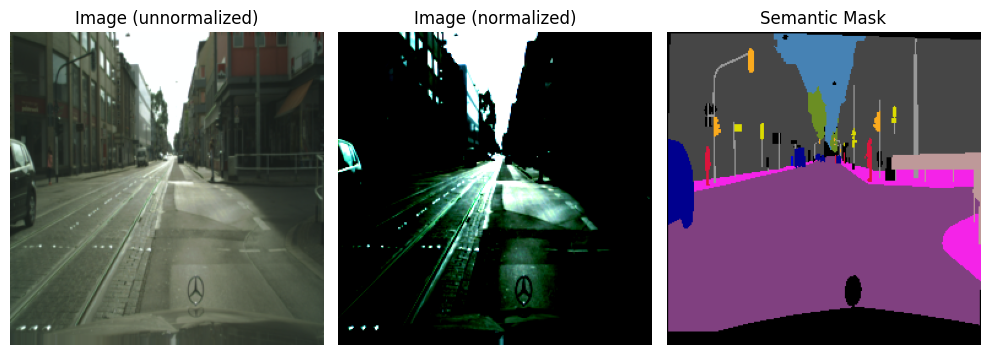

In [228]:
import matplotlib.pyplot as plt

# Get one batch
images, masks = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")   # [B, 3, H, W]
print(f"Mask batch shape: {masks.shape}")     # [B, 1, H, W] or [B, H, W]

# Visualize the first sample
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Image (unnormalized)")
img = images[0].permute(1, 2, 0).cpu().numpy()
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Unn
plt.imshow(img.clip(0, 1))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image (normalized)")
img_norm = images[0].permute(1, 2, 0).cpu().numpy()
plt.imshow(img_norm.clip(0, 1))
plt.axis("off")


mask = convert_label_to_color(masks[0].cpu().numpy())
plt.subplot(1, 3, 3)
plt.title("Semantic Mask")
plt.imshow(mask)
plt.axis("off")
plt.tight_layout()
plt.show()


In [108]:
import torchvision.models.segmentation as models
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

weights = DeepLabV3_ResNet101_Weights.DEFAULT
model = models.deeplabv3_resnet101(weights=weights)  # do not pass num_classes here

# Modify the classifier to output 19 classes (for Cityscapes)
model.classifier[4] = torch.nn.Conv2d(256, 19, kernel_size=(1, 1))

In [ ]:
from torch.ao.quantization import fuse_modules

def fuse_deeplabv3_resnet101(model):
    fuse_modules(model.backbone,
                          ['conv1', 'bn1', 'relu'],
                          inplace=True)

    for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
        for block in getattr(model.backbone, layer_name):
            fuse_modules(block, ['conv1', 'bn1', 'relu'], inplace=True)
            fuse_modules(block, ['conv2', 'bn2'], inplace=True)
            fuse_modules(block, ['conv3', 'bn3'], inplace=True)

            if block.downsample is not None:
                fuse_modules(block.downsample, ['0', '1'], inplace=True)

    return model

def fuse_deeplabv3_head(model):

    head = model.classifier
    aspp = head[0]                    
    for conv_mod in aspp.convs[:-1]:
        fuse_modules(conv_mod, ['0', '1', '2'], inplace=True)
    fuse_modules(aspp.convs[-1], ['1', '2', '3'], inplace=True)
    fuse_modules(aspp.project, ['0', '1', '2'], inplace=True)
    fuse_modules(head, ['1', '2', '3'], inplace=True)

    return model


In [111]:
import torch
from torch.ao.quantization import QConfig
from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import MinMaxObserver
from torch.ao.quantization.quantize_fx import fuse_fx, prepare_fx, convert_fx
from torchvision.datasets import Cityscapes
from torchvision.transforms import ToTensor

device = torch.device('cpu')
torch.backends.quantized.engine = 'qnnpack'
model = model.to(device).eval()

# 1) Build/load your model & fuse it (backbone + head + aux)
fuse_deeplabv3_resnet101(model)
fuse_deeplabv3_head(model)
torch.ao.quantization.fuse_modules(model.aux_classifier, ['0','1','2'], inplace=True)

# 2) Create FakeQuantize observers with explicit min/max
act_fake_quant = FakeQuantize.with_args(
    observer=MinMaxObserver,
    quant_min=0,    # uint8 activations
    quant_max=255,
    dtype=torch.quint8,
    qscheme=torch.per_tensor_affine
)
weight_fake_quant = FakeQuantize.with_args(
    observer=MinMaxObserver,
    quant_min=-127, # int8 symmetric weights
    quant_max=127,
    dtype=torch.qint8,
    qscheme=torch.per_tensor_symmetric
)

# 3) Build a QConfig and wrap it in the old dict API
qcfg = QConfig(activation=act_fake_quant, weight=weight_fake_quant)
qconfig_dict = {"": qcfg}

# 4) FX‐fuse Conv+BN(+ReLU)
model_fused = fuse_fx(model, qconfig_dict)

# 5) Prepare for static quantization (inserts observers)
example_inputs = (torch.randn(1,3,256,256,device=device),)
model_prepared = prepare_fx(model_fused, qconfig_dict, example_inputs)


====== ====== ====== ====== ====== ====== ====== ====== ====== ====== 
Fusing Block:  Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
first submodule check 
Second submodule check 
third submodule check 
====== ====== ====== ====== ====== ====== ====== ====== ====== ====== 
Fusing Block:  Bottleneck(
  (co

/var/folders/_y/zkbt2blx4lz584xbj0zsmf8r0000gn/T/ipykernel_61495/2281586790.py:39: FutureWarning: Passing a fuse_custom_config_dict to fuse is deprecated and will not be supported in a future version. Please pass in a FuseCustomConfig instead.
  model_fused = fuse_fx(model, qconfig_dict)
/Users/christosntokos/Projects/NNCV/nncv_venv/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  prepared = prepare(


In [ ]:
# 6) Calibrate on a few batches
def custom_transform(img, target):
    return ToTensor()(img), ToTensor()(target)

calib_ds = Cityscapes(
    root='/Users/christosntokos/Downloads/data/cityscapes',
    split="train",
    mode="fine",
    target_type="semantic",
    transforms=custom_transform
)
with torch.no_grad():
    for i, (img, _) in enumerate(calib_ds):
        if i >= 10: break
        img = img.unsqueeze(0).to(device)
        model_prepared(img)

# 7) Convert to a true quantized model
model_quantized = convert_fx(model_prepared)

# 8) (Optional) inspect the FX graph for fused/quantized ops
for node in model_fused.graph.nodes:
    t = str(node.target)
    if "fused" in t or "quantized::conv" in t:
        print(node)


In [118]:
import torch
from collections import Counter

def inspect_quantized_model(model):
    # 1) Check parameter dtypes
    dtype_counts = Counter(p.dtype for p in model.parameters())
    print("📦 Parameter dtypes:")
    for dt, cnt in dtype_counts.items():
        print(f"  • {dt}: {cnt} parameters")

    # 2) Check for packed params on quantized convs
    packed = [name for name, m in model.named_modules() if hasattr(m, "_packed_params")]
    print(f"\n🔩 Modules with packed (int8) params: {len(packed)}")
    for name in packed[:10]:
        print(f"  • {name}")
    if len(packed) > 10:
        print("  …")

    # 3) List any modules whose class name includes "Quantized"
    quant_modules = []
    for name, m in model.named_modules():
        cls_name = type(m).__name__
        mod_path = type(m).__module__
        if "quantized" in mod_path.lower() or "quantized" in cls_name.lower():
            quant_modules.append((name, f"{mod_path}.{cls_name}"))
    print(f"\n🔍 Quantized‐type submodules: {len(quant_modules)}")
    for name, full_cls in quant_modules[:10]:
        print(f"  • {name}: {full_cls}")
    if len(quant_modules) > 10:
        print("  …")

# Run it:
inspect_quantized_model(model_quantized)




📦 Parameter dtypes:

🔩 Modules with packed (int8) params: 114
  • backbone.conv1.0
  • backbone.layer1.0.conv1.0
  • backbone.layer1.0.conv2
  • backbone.layer1.0.conv3
  • backbone.layer1.0.downsample.0
  • backbone.layer1.1.conv1.0
  • backbone.layer1.1.conv2
  • backbone.layer1.1.conv3
  • backbone.layer1.2.conv1.0
  • backbone.layer1.2.conv2
  …

🔍 Quantized‐type submodules: 116
  • backbone.conv1.0: torch.ao.nn.intrinsic.quantized.modules.conv_relu.ConvReLU2d
  • backbone.layer1.0.conv1.0: torch.ao.nn.intrinsic.quantized.modules.conv_relu.ConvReLU2d
  • backbone.layer1.0.conv2: torch.ao.nn.quantized.modules.conv.Conv2d
  • backbone.layer1.0.conv3: torch.ao.nn.quantized.modules.conv.Conv2d
  • backbone.layer1.0.downsample.0: torch.ao.nn.quantized.modules.conv.Conv2d
  • backbone.layer1.1.conv1.0: torch.ao.nn.intrinsic.quantized.modules.conv_relu.ConvReLU2d
  • backbone.layer1.1.conv2: torch.ao.nn.quantized.modules.conv.Conv2d
  • backbone.layer1.1.conv3: torch.ao.nn.quantized.modul

In [307]:
def summarize_trainable_layers(model):
    trainable = []
    frozen = []
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable.append(name)
        else:
            frozen.append(name)
    
    print("🔓 Trainable Layers:")
    for name in trainable:
        print(f"  {name}")
    
    print("\n🔒 Frozen Layers:")
    for name in frozen:
        print(f"  {name}")

    return trainable, frozen

In [309]:
for param in model.parameters():
    param.requires_grad = True

for name, param in model.backbone.named_parameters():
    if "layer3" not in name and "layer4" not in name:
        param.requires_grad = False

summarize_trainable_layers(model)

🔓 Trainable Layers:
  backbone.layer3.0.conv1.weight
  backbone.layer3.0.bn1.weight
  backbone.layer3.0.bn1.bias
  backbone.layer3.0.conv2.weight
  backbone.layer3.0.bn2.weight
  backbone.layer3.0.bn2.bias
  backbone.layer3.0.conv3.weight
  backbone.layer3.0.bn3.weight
  backbone.layer3.0.bn3.bias
  backbone.layer3.0.downsample.0.weight
  backbone.layer3.0.downsample.1.weight
  backbone.layer3.0.downsample.1.bias
  backbone.layer3.1.conv1.weight
  backbone.layer3.1.bn1.weight
  backbone.layer3.1.bn1.bias
  backbone.layer3.1.conv2.weight
  backbone.layer3.1.bn2.weight
  backbone.layer3.1.bn2.bias
  backbone.layer3.1.conv3.weight
  backbone.layer3.1.bn3.weight
  backbone.layer3.1.bn3.bias
  backbone.layer3.2.conv1.weight
  backbone.layer3.2.bn1.weight
  backbone.layer3.2.bn1.bias
  backbone.layer3.2.conv2.weight
  backbone.layer3.2.bn2.weight
  backbone.layer3.2.bn2.bias
  backbone.layer3.2.conv3.weight
  backbone.layer3.2.bn3.weight
  backbone.layer3.2.bn3.bias
  backbone.layer3.3.conv1

(['backbone.layer3.0.conv1.weight',
  'backbone.layer3.0.bn1.weight',
  'backbone.layer3.0.bn1.bias',
  'backbone.layer3.0.conv2.weight',
  'backbone.layer3.0.bn2.weight',
  'backbone.layer3.0.bn2.bias',
  'backbone.layer3.0.conv3.weight',
  'backbone.layer3.0.bn3.weight',
  'backbone.layer3.0.bn3.bias',
  'backbone.layer3.0.downsample.0.weight',
  'backbone.layer3.0.downsample.1.weight',
  'backbone.layer3.0.downsample.1.bias',
  'backbone.layer3.1.conv1.weight',
  'backbone.layer3.1.bn1.weight',
  'backbone.layer3.1.bn1.bias',
  'backbone.layer3.1.conv2.weight',
  'backbone.layer3.1.bn2.weight',
  'backbone.layer3.1.bn2.bias',
  'backbone.layer3.1.conv3.weight',
  'backbone.layer3.1.bn3.weight',
  'backbone.layer3.1.bn3.bias',
  'backbone.layer3.2.conv1.weight',
  'backbone.layer3.2.bn1.weight',
  'backbone.layer3.2.bn1.bias',
  'backbone.layer3.2.conv2.weight',
  'backbone.layer3.2.bn2.weight',
  'backbone.layer3.2.bn2.bias',
  'backbone.layer3.2.conv3.weight',
  'backbone.layer3.2.

In [298]:
def train(loader, model, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0

    for i, (images, masks) in enumerate(loader):
        print(f"Batch {i+1}/{len(loader)}")
        
        model_name = model.__class__.__name__
        if model_name == "DeepLabV3":
            outputs = model(images)["out"]
        else:   
            outputs = model(images)

        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({
                "train_loss": loss.item(),
                "learning_rate": optimizer.param_groups[0]['lr'],
                "epoch": epoch + 1,
            }, step=epoch * len(train_loader) + i)

        running_loss += loss.item()
        print(f"Batch {i+1}/{len(loader)}, Loss: {loss.item()}")
        break
        

    avg_loss = running_loss / len(loader)
    return avg_loss

In [25]:
val_dataset = Cityscapes(
    '/Users/christosntokos/Downloads/data/cityscapes',
    split="val",
    mode="fine",
    target_type="semantic",
    transforms=custom_transform  # reuse the same transforms
)

In [26]:
val_loader = DataLoader(
    val_dataset,
    batch_size=4,  # smaller batch size is fine for validation
    shuffle=False,
    num_workers=0,  # or >0 if you're past multiprocessing issues
    pin_memory=True
)

In [ ]:
@torch.no_grad()
def validate(model, loader, criterion, device, epoch, output_dir):
    model.eval()
    total_loss = 0.0
    total_acc, total_iou = 0.0, 0.0

    for i, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        model_name = model.__class__.__name__
        if model_name == "DeepLabV3":
            outputs = model(images)["out"]
        else:   
            outputs = model(images)  
                  
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        predictions = outputs.argmax(1)
        acc = compute_pixel_accuracy(predictions, labels)
        miou = compute_mIoU(predictions, labels)
        total_acc += acc
        total_iou += miou

        if i == 0:
            predictions = outputs.softmax(1).argmax(1)

            predictions = predictions.unsqueeze(1)
            labels = labels.unsqueeze(1)

            predictions = convert_train_id_to_color(predictions)
            labels = convert_train_id_to_color(labels)

            predictions_img = make_grid(predictions.cpu(), nrow=8)
            labels_img = make_grid(labels.cpu(), nrow=8)

            predictions_img = predictions_img.permute(1, 2, 0).numpy()
            labels_img = labels_img.permute(1, 2, 0).numpy()

            wandb.log({
                "predictions": [wandb.Image(predictions_img)],
                "labels": [wandb.Image(labels_img)],
            }, step=(epoch + 1) * len(loader) - 1)
    valid_loss = sum(total_loss) / len(loader)
    avg_acc = total_acc / len(loader)
    avg_miou = total_iou / len(loader)

    wandb.log({
        "valid_loss": valid_loss,
        "pixel_accuracy": avg_acc,
        "mIoU": avg_miou,
    }, step=(epoch + 1) * len(loader) - 1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        if current_best_model_path:
            os.remove(current_best_model_path)
        current_best_model_path = os.path.join(
            output_dir, 
            f"best_model-epoch={epoch:04}-val_loss={valid_loss:04}.pth"
        )
        torch.save(model.state_dict(), current_best_model_path)
        
    return valid_loss


Batch 1/309
Batch 1/309, Loss: 3.1295862197875977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Validation Loss: 2.9581732749938965


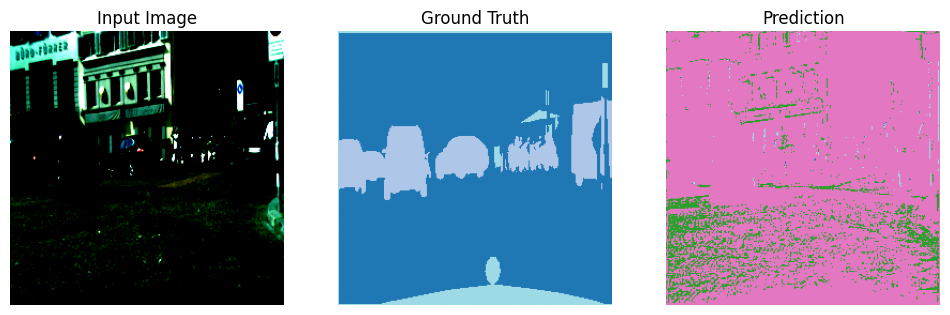

Epoch 1/10
   Train Loss: 0.0101
   Val Loss:   0.0235


In [19]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train(train_loader, model, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss:   {val_loss:.4f}")
    break


In [20]:
import torchvision.models.segmentation as models
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

# Use the new weights argument
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = models.deeplabv3_resnet50(weights=weights)

# Modify the classifier to output 19 classes (for Cityscapes)
model.classifier[4] = torch.nn.Conv2d(256, 19, kernel_size=(1, 1))

using model:  DeepLabV3
Batch 1/309
Batch 1/309, Loss: 2.413118839263916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0598185..2.64].


Validation Loss: 2.1176559925079346


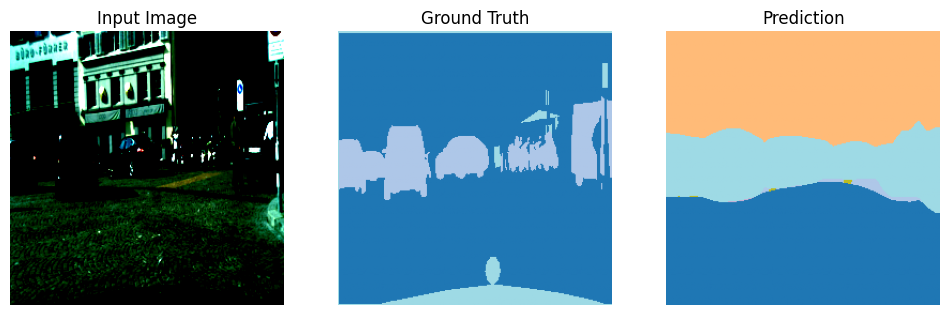

Epoch 1/10
   Train Loss: 0.0078
   Val Loss:   0.0168


In [ ]:
num_epochs = 10

optimizer = torch.optim.AdamW([
    {"params": model.backbone.parameters(), "lr": 1e-5},
    {"params": model.classifier.parameters(), "lr": 1e-4}
], weight_decay=1e-4)

print("using model: ", model.__class__.__name__)
for epoch in range(num_epochs):
    train_loss = train(train_loader, model, optimizer, criterion)
    val_loss = validate(model, val_loader, criterion)
 
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss:   {val_loss:.4f}")
    break
